# Hypotheses Testing Project with data from the Northwind database


### Importing libraries and connecting SQL database

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flatiron_stats as fs
import numpy as np
from IPython.display import Image
import scipy.stats

from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()


#connection to SQL database
conn = sqlite3.connect('Northwind_small.sqlite')
cur  = conn.cursor()

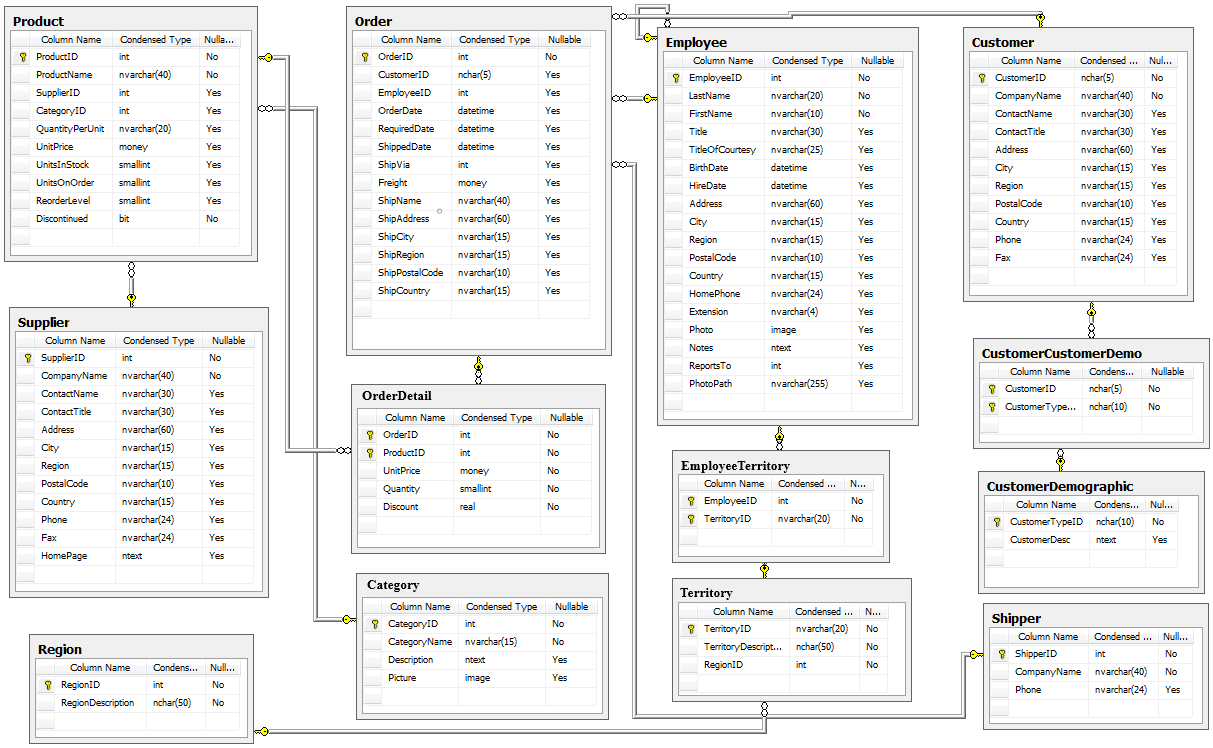

In [2]:
Image("Northwind_ERD_updated.png")

## Q1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Initial data exploration

In [4]:
#SQL query
order_detail = cur.execute('''SELECT * FROM OrderDetail;''').fetchall()

#Creating Pandas DF with fetched data and renaming columns
order_detail_df = pd.DataFrame(order_detail)
order_detail_df.columns = ['orderID/productID','orderID','productID','unit_price','quantity','discount']

#Crating a new column which calculates the total price of each product(quantity x price)
order_detail_df['total_price'] = order_detail_df.apply(lambda row: row.unit_price * row.quantity, axis = 1) 
order_detail_df['total_price_ad'] = order_detail_df.apply(lambda row: row.total_price-(row.total_price * row.discount), axis = 1) 


order_detail_df.head(10)

,orderID/productID,orderID,productID,unit_price,quantity,discount,total_price,total_price_ad
0,10248/11,10248,11,14.0,12,0.00,168.0,168.00
1,10248/42,10248,42,9.8,10,0.00,98.0,98.00
2,10248/72,10248,72,34.8,5,0.00,174.0,174.00
3,10249/14,10249,14,18.6,9,0.00,167.4,167.40
4,10249/51,10249,51,42.4,40,0.00,1696.0,1696.00
5,10250/41,10250,41,7.7,10,0.00,77.0,77.00
6,10250/51,10250,51,42.4,35,0.15,1484.0,1261.40
7,10250/65,10250,65,16.8,15,0.15,252.0,214.20
8,10251/22,10251,22,16.8,6,0.05,100.8,95.76
9,10251/57,10251,57,15.6,15,0.05,234.0,222.30


In [5]:
order_detail_df.discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: discount, dtype: int64

We can see that the main discount categories are: 
* 5%
* 10%
* 15%
* 20%
* 25%

Smaller discount rates exist in the database, but are very rare (8 rows out of 2155)
I will only consider the above mentioned discount rates for answering the question to avoid creating unnecessary 
discount categories.

In [6]:
# total sales for different discount rates
sales_per_discount_1 = order_detail_df.groupby('discount').sum()
sales_per_discount_2 = sales_per_discount_1.sort_values(by='quantity',ascending=False, axis=0).head(6)
sales_per_discount_2 = sales_per_discount_2.drop('orderID', axis=1)
sales_per_discount_2 = sales_per_discount_2.drop('productID', axis=1)
sales_per_discount_2 = sales_per_discount_2.drop('unit_price', axis=1)
sales_per_discount_2

,quantity,total_price,total_price_ad
discount,,,
0.00,28599,750698.61,750698.6100
0.05,5182,155386.71,147617.3745
0.15,4456,102948.44,87506.1740
0.10,4366,101665.71,91499.1390
0.20,4351,111476.38,89181.1040
0.25,4349,131918.09,98938.5675


This table shows us the main discount categories, number of total products sold and the total price.
28599 products were sold without any discount.
Between 4349 and 5182 products were sold per each discount category - total of 22704.

### Preparing variables for hypotheses testing

In [7]:
#Fetching quantity of productd sold for each discount category
#discount_0 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.0;''').fetchall()
#discount_5 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.05;''').fetchall()
#discount_10 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.1;''').fetchall()
#discount_15 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.15;''').fetchall()
#discount_20 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.2;''').fetchall()
#discount_25 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.25;''').fetchall()

#Removing outliers (quantities higher than 100)
discount_0 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.0 and quantity <100;''').fetchall()
discount_5 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.05 and quantity <100;''').fetchall()
discount_10 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.1 and quantity <100;''').fetchall()
discount_15 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.15 and quantity <100;''').fetchall()
discount_20 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.2 and quantity <100;''').fetchall()
discount_25 = cur.execute('''SELECT quantity FROM OrderDetail WHERE discount = 0.25 and quantity <100;''').fetchall()

#This query resulted in a list of tuples. This function transforms there variables into lists.
def tuple_to_list(item):
    results = []
    for t in item: 
        for x in t: 
            results.append(x) 
    return results

disc_0 = tuple_to_list(discount_0)
disc_5 = tuple_to_list(discount_5)
disc_10 = tuple_to_list(discount_10)
disc_15 = tuple_to_list(discount_15)
disc_20 = tuple_to_list(discount_20)
disc_25 = tuple_to_list(discount_25)

#These two variable are arrays for products sold with some discount(includes all discount categories) and without
#any discount
overall = np.array(disc_0 + disc_5 + disc_10 + disc_15 + disc_20 + disc_25)
no_discount = np.array(disc_0)
some_discount = np.array(disc_5 + disc_10 + disc_15 + disc_20 + disc_25)



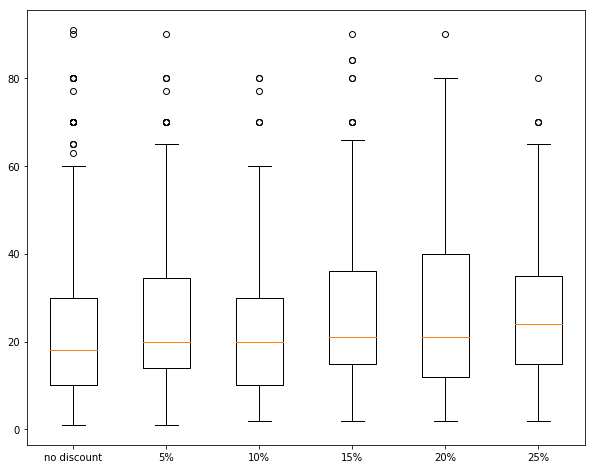

In [17]:

fig = plt.figure(1,figsize=(10,8))
ax = fig.add_subplot(111)
to_plot = ax.boxplot([disc_0,disc_5,disc_10,disc_15,disc_20,disc_25],labels=['no discount','5%','10%','15%','20%','25%'])

The **median quantity** of products order increases slighltly with a discount applied.
* No discount =  **18**
* Overall = **20**
* 5%,10% = **20**
* 15%,20% = **21**
* 25% = **24**


### Hypothesis (1)

**Ho: Discount does not increase the number of products sold.**

**H1: Discount does have a statistically significant effect on the increase of the number of products sold.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test

Let's treat no_discount as the control group and some_discount as the experimental group

### Welch's T-Test

In [8]:
fs.p_value_welch_ttest(no_discount, some_discount, two_sided=False)

1.1288081580573817e-11

**Result: 1.1288081580573817e-11**

This very small p-value indicates that there is a statistically significant effect of discount on the quantity of products sold. 

### Effect size

In [24]:
#This function calculates Cohen's D - the difference between two means, measured in standard deviations.

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

Cohen_d(some_discount,no_discount) #first experimental group, second is control group

0.3116249688964361

**Result: 0.31 - small positive effect.**
A positive effect size indicates that the effect increases the mean.
This means that the discount has a small positive effect on the number of products ordered.

### Hypothesis (2)

**Ho: There is no statistically significant difference between various discount levels and their effect on increasing quantity of product sold.**

**H1: There are discount levels that have statistically significant effect on increasing the quantity of products sold.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test

In [22]:
scipy.stats.f_oneway(disc_5, disc_10, disc_15, disc_20, disc_25)

F_onewayResult(statistic=1.1843556566943465, pvalue=0.3161974897360752)

**Result: 0.316**
This high p-value indicates that there is no statistically significant difference between those groups.


### Hypothesis (3)

**Ho: Compared to no discount there is no statistically significant difference between various discount levels and their effect on increasing quantity of product sold.**

**H1: There are discount levels that have statistically significant effect on increasing the quantity of products sold, compared no no discount at all.**

**$\alpha$: 0.05**

I will perform a 1-sided test

I will first perform Welch's T-test across all discount levels in comparison with no discount.

In [21]:
discounts = [disc_5, disc_10, disc_15, disc_20, disc_25]

for item in discounts:
    item = np.array(item)
    results = fs.p_value_welch_ttest(no_discount, item, two_sided=False)
    print('This is the p-value for no_discount and separate discount variables:')
    print(results)

This is the p-value for no_discount and separate discount variables:
0.00011015097977618016
This is the p-value for no_discount and separate discount variables:
0.03140764110408012
This is the p-value for no_discount and separate discount variables:
4.2947873018173155e-05
This is the p-value for no_discount and separate discount variables:
0.00010702250945293645
This is the p-value for no_discount and separate discount variables:
5.217000575719055e-05


All of these p-values are very small, which suggests there is a significant difference between their means and the mean of the no_discount variable.
Discount levels **15% and 25% have much lower p-value** than other groups.
**10% discount has the highest p-value of 0.03**

Which discount level has the biggest effect size?

In [25]:
for item in discounts:
    item = np.array(item)
    results = Cohen_d(item,no_discount)
    print('This is effect size for no_discount and separate discount variables:')
    print(results)

This is effect size for no_discount and separate discount variables:
0.35196133789659617
This is effect size for no_discount and separate discount variables:
0.16235556161327822
This is effect size for no_discount and separate discount variables:
0.40701280436876425
This is effect size for no_discount and separate discount variables:
0.35499791035177525
This is effect size for no_discount and separate discount variables:
0.3653568580130326


These results indicate that the discount rates with the biggest effect size are:
* 15% - effect size of 0.4
* 25%, 20%, 5% - effect size 0.35-0.36

10% has the lowest effect size - 0.1

### What does a Cohen's D of 0.4  mean?

* with a Cohen's d of 0.4, 66 % of the treatment group will be above the mean of the control group
* there is a 61 % chance that a variable picked at random from the treatment group(15% discount) will have a higher score than a variable picked at random from the control group (no discount) = probability of superiority.

NEXT STEP: Calculating power - I know alpha, effect size and sample size

In [42]:
import statsmodels

statsmodels.stats.power.tt_ind_solve_power(alpha=0.05, effect_size=0.407, nobs1=len(disc_0), ratio=None, alternative=None)

ValueError: need exactly one keyword that is None

In [48]:
###power analysis for disc_0 and disc_15
power_analysis.solve_power(alpha=0.05, effect_size=0.407, nobs1=len(disc_15))

0.9465004142122686

### Summary of findings after hypotheses 1,2 and 3

* Discounts have statistically significant effect on increasing the quantity of sold products
* When compared to each other, there is no significant difference between the discount levels themselves
* However, compared to no discount at all, the most effective discount levels is 15%
* 25%, 20% and 5% have a similar effect 
* The least effective discount level is 10%

### Defining hypothesis 2

**Ho: Discounts do not increase the overall revenue.**

**H1: Discounts do have a statistically significant effect on the increase of revenue.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test

In [26]:
#preparing variables for testing

order_detail_df.head()

rev_0 = order_detail_df.loc[(order_detail_df['discount']==0.0) & (order_detail_df['total_price_ad']<6000)]
rev_5 = order_detail_df.loc[(order_detail_df['discount']==0.05) & (order_detail_df['total_price_ad']<6000)]
rev_10 = order_detail_df.loc[(order_detail_df['discount']==0.1) & (order_detail_df['total_price_ad']<6000)]
rev_15 = order_detail_df.loc[(order_detail_df['discount']==0.15) & (order_detail_df['total_price_ad']<6000)]
rev_20 = order_detail_df.loc[(order_detail_df['discount']==0.20) & (order_detail_df['total_price_ad']<6000)]
rev_25 = order_detail_df.loc[(order_detail_df['discount']==0.25) & (order_detail_df['total_price_ad']<6000)]

revenue_0 = list(rev_0.total_price_ad)
revenue_5 = list(rev_5.total_price_ad)
revenue_10 = list(rev_10.total_price_ad)
revenue_15 = list(rev_15.total_price_ad)
revenue_20 = list(rev_20.total_price_ad)
revenue_25 = list(rev_25.total_price_ad)

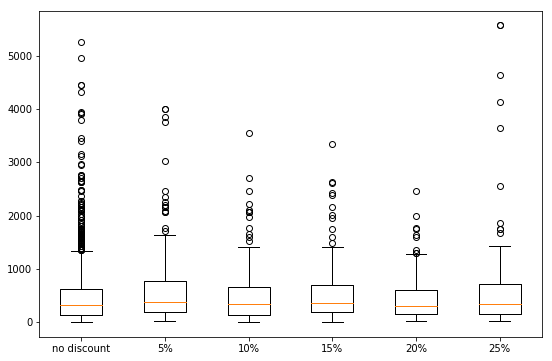

In [27]:
fig = plt.figure(1,figsize=(9,6))
ax = fig.add_subplot(111)
to_plot = ax.boxplot([revenue_0, revenue_5, revenue_10, revenue_15, revenue_20, revenue_25],labels=['no discount','5%','10%','15%','20%','25%'])

### Welch's T-test

In [28]:
total_rev_any_discount = revenue_5 + revenue_10 + revenue_15 + revenue_20 +revenue_25

revenue_no_disc = np.array(revenue_0)
revenue_any_disc = np.array(total_rev_any_discount)


fs.p_value_welch_ttest(revenue_no_disc, revenue_any_disc, two_sided=False)

0.03918142747864817

**Result: 0.07**
This p-value is higher than our alpha of 0.05. We can this reject the alternative hypothesis.

If we do not consider the after discount price:
**Result: 5.248554325509858e-05**
This a very small p-value, which suggests statistically signifiant between revenues with discount and without

In [29]:
Cohen_d(revenue_any_disc,revenue_no_disc) #first experimental group, second is control group

0.0799311741351135

**Result: 0.179**
This suggests an extremely small positive effect

## Which discount level is the most significant for increasing revenue?

In [30]:
scipy.stats.f_oneway(revenue_0,revenue_5, revenue_10, revenue_15, revenue_20, revenue_25)

F_onewayResult(statistic=2.560859982040898, pvalue=0.025582079604695062)

In [31]:
list_rev_any_disc = [revenue_5, revenue_10, revenue_15, revenue_20, revenue_25]

for item in list_rev_any_disc:
    item = np.array(item)
    results = fs.p_value_welch_ttest(revenue_no_disc, item, two_sided=False)
    print('This is the p-value for no_discount and separate discount variables:')
    print(results)

This is the p-value for no_discount and separate discount variables:
0.007483442074049718
This is the p-value for no_discount and separate discount variables:
0.3571112450630549
This is the p-value for no_discount and separate discount variables:
0.17679823296488628
This is the p-value for no_discount and separate discount variables:
0.0750348493325993
This is the p-value for no_discount and separate discount variables:
0.10124275284056972


In [32]:
for item in list_rev_any_disc:
    item = np.array(item)
    results = Cohen_d(item,revenue_no_disc)
    print('This is effect size for no_discount and separate discount variables:')
    print(results)

This is effect size for no_discount and separate discount variables:
0.22677762098149612
This is effect size for no_discount and separate discount variables:
0.0285701481989444
This is effect size for no_discount and separate discount variables:
0.07548674272370728
This is effect size for no_discount and separate discount variables:
-0.09380788417089762
This is effect size for no_discount and separate discount variables:
0.1456962842770064


In [20]:
#SQL query
order = cur.execute('''SELECT * FROM [Order];''').fetchall()

#Creating Pandas DF with fetched data and renaming columns
order_df = pd.DataFrame(order)
order_df.columns = ['orderID','customerID','empl_ID','order_d','req_date','ship_date','ship_via','freight','s_name','s_address','s_city','s_region','s_code','s_country']

In [21]:
order_df.head()

,orderID,customerID,empl_ID,order_d,req_date,ship_date,ship_via,freight,s_name,s_address,s_city,s_region,s_code,s_country
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


## Q2: Does the company receive larger orders in the two months preceding Christmas?

**Ho: The company does not receive significantly larger orders into two months preceding Christmas compared to other two-month section of the year**

**H1: Discount does have a statistically significant effect on the increase of the number of products sold.**
   
**$\alpha$: 0.05**

I will perform a 1-sided test


In [22]:
#preparing varibles

order_sizes = order_detail_df.groupby('orderID').sum()


#setting new index

order_index = order_df.set_index('orderID')


#joining tables
joined_df = order_index.join(order_sizes)

#dropping columns
orders = joined_df.drop(['customerID','empl_ID','ship_via','freight','s_name','s_address','s_code','productID','unit_price','discount','total_price'],axis=1)

#changing columns into datetime objects
orders['order_d'] = pd.to_datetime(orders['order_d'])

#slicing df into four quarters of the year
first_q = orders[orders.order_d.dt.month.isin([1,2,3])]
second_q = orders[orders.order_d.dt.month.isin([4,5,6])]
third_q = orders[orders.order_d.dt.month.isin([7,8,9])]
fourth_q = orders[orders.order_d.dt.month.isin([10,11,12])]

#getting variables
first_qq = np.array(first_q.quantity)
second_qq = np.array(second_q.quantity)
third_qq = np.array(third_q.quantity)
fourth_qq = np.array(fourth_q.quantity)

all_quarters = [first_qq,second_qq,third_qq,fourth_qq]

In [23]:
#exploring means
print('The average quanity of each product ordered:')
print('1st quarter: '+str(first_qq.mean()))
print('2nd quarter: '+str(second_qq.mean()))
print('3rd quarter: '+str(third_qq.mean()))
print('4th quarter: '+str(fourth_qq.mean()))

The average quanity of each product ordered:
1st quarter: 61.85766423357664
2nd quarter: 62.49723756906077
3rd quarter: 58.76300578034682
4th quarter: 63.81188118811881


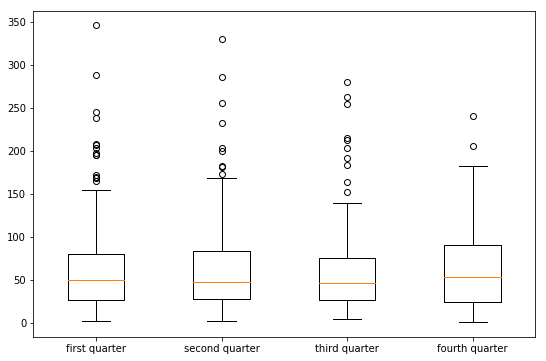

In [24]:
fig = plt.figure(1,figsize=(9,6))
ax = fig.add_subplot(111)
to_plot = ax.boxplot(all_quarters,labels=['first quarter','second quarter','third quarter','fourth quarter'])

F-one-way test

In [25]:
scipy.stats.f_oneway(first_qq,second_qq,third_qq,fourth_qq)

F_onewayResult(statistic=0.3229822291389121, pvalue=0.8087609911036548)

Welch's T-test across variables

In [26]:

for item in all_quarters[0:3]:
    item = np.array(item)
    results = fs.p_value_welch_ttest(fourth_qq, item, two_sided=False)
    print('This is the p-value for no_discount and separate discount variables:')
    print(results)

This is the p-value for no_discount and separate discount variables:
0.3339529664847365
This is the p-value for no_discount and separate discount variables:
0.40059379803391826
This is the p-value for no_discount and separate discount variables:
0.16061960307027368


## Is there a significant difference between continets and their order size before Christmas?

In [27]:
fourth_q.s_region.value_counts()
#I will remove Eastern Europe, Central Ameria and Scandinavia from the selection due to small number of samples

Western Europe     68
North America      37
South America      30
British Isles      25
Northern Europe    16
Southern Europe    13
Scandinavia         6
Central America     5
Eastern Europe      2
Name: s_region, dtype: int64

In [28]:
all_regions = ['British Isles','Western Europe','North America', 
               'Southern Europe','Northern Europe','South America']

In [29]:
BI = np.array(fourth_q.loc[fourth_q.s_region == all_regions[0],'quantity'])
WE = np.array(fourth_q.loc[fourth_q.s_region == all_regions[1],'quantity'])
NA = np.array(fourth_q.loc[fourth_q.s_region == all_regions[2],'quantity'])
SE = np.array(fourth_q.loc[fourth_q.s_region == all_regions[3],'quantity'])
NE = np.array(fourth_q.loc[fourth_q.s_region == all_regions[4],'quantity'])
SA = np.array(fourth_q.loc[fourth_q.s_region == all_regions[5],'quantity'])

fourth_q_all_regions = [BI,WE,NA,SE,NE,SA]

In [30]:
NA

array([241,  50,  66,  35, 108, 105,  56,  24,  38,  25,  42,  38,  81,
       176,  20, 150, 111,  38, 117,  52,   9, 174, 182, 137,  55, 140,
        15,  21,  22,  94, 105, 112,  67,  91,  53,   9,  20], dtype=int64)

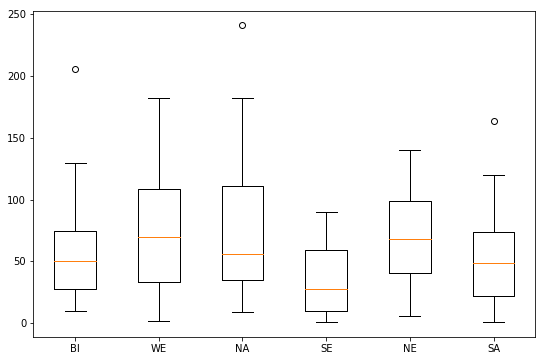

In [31]:
fig = plt.figure(1,figsize=(9,6))
ax = fig.add_subplot(111)
to_plot = ax.boxplot(fourth_q_all_regions,labels=['BI','WE','NA','SE','NE','SA'])

In [32]:
scipy.stats.f_oneway(BI,WE,NA,SE,NE,SA)

F_onewayResult(statistic=2.905382526528915, pvalue=0.015031654106101354)

In [42]:
for item in fourth_q_all_regions:
    results = fs.p_value_welch_ttest(NA, item, two_sided=False)
    print('TEXT:')
    print(results)

TEXT:
0.05669733199664451
TEXT:
0.34743206868423737
TEXT:
0.5
TEXT:
0.00028385064794600456
TEXT:
0.31349335462765127
TEXT:
0.013703462969518743


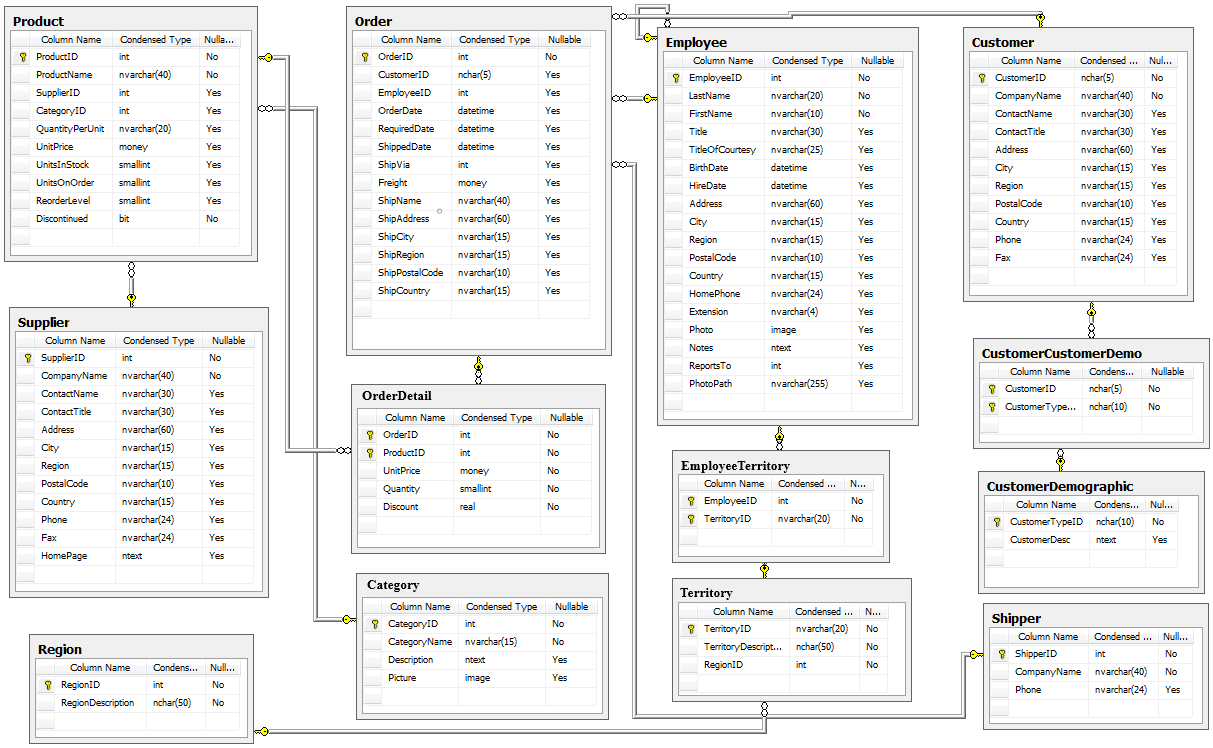

In [50]:
Image("Northwind_ERD_updated.png")

In [52]:
cur.execute('''SELECT * FROM Product;''').fetchall()

[(1, 'Chai', 1, 1, '10 boxes x 20 bags', 18, 39, 0, 10, 0),
 (2, 'Chang', 1, 1, '24 - 12 oz bottles', 19, 17, 40, 25, 0),
 (3, 'Aniseed Syrup', 1, 2, '12 - 550 ml bottles', 10, 13, 70, 25, 0),
 (4, "Chef Anton's Cajun Seasoning", 2, 2, '48 - 6 oz jars', 22, 53, 0, 0, 0),
 (5, "Chef Anton's Gumbo Mix", 2, 2, '36 boxes', 21.35, 0, 0, 0, 1),
 (6,
  "Grandma's Boysenberry Spread",
  3,
  2,
  '12 - 8 oz jars',
  25,
  120,
  0,
  25,
  0),
 (7,
  "Uncle Bob's Organic Dried Pears",
  3,
  7,
  '12 - 1 lb pkgs.',
  30,
  15,
  0,
  10,
  0),
 (8, 'Northwoods Cranberry Sauce', 3, 2, '12 - 12 oz jars', 40, 6, 0, 0, 0),
 (9, 'Mishi Kobe Niku', 4, 6, '18 - 500 g pkgs.', 97, 29, 0, 0, 1),
 (10, 'Ikura', 4, 8, '12 - 200 ml jars', 31, 31, 0, 0, 0),
 (11, 'Queso Cabrales', 5, 4, '1 kg pkg.', 21, 22, 30, 30, 0),
 (12, 'Queso Manchego La Pastora', 5, 4, '10 - 500 g pkgs.', 38, 86, 0, 0, 0),
 (13, 'Konbu', 6, 8, '2 kg box', 6, 24, 0, 5, 0),
 (14, 'Tofu', 6, 7, '40 - 100 g pkgs.', 23.25, 35, 0, 0, 0),
 

In [54]:
cur.execute('''SELECT * FROM [Orderdetail];''').fetchall()

[('10248/11', 10248, 11, 14, 12, 0.0),
 ('10248/42', 10248, 42, 9.8, 10, 0.0),
 ('10248/72', 10248, 72, 34.8, 5, 0.0),
 ('10249/14', 10249, 14, 18.6, 9, 0.0),
 ('10249/51', 10249, 51, 42.4, 40, 0.0),
 ('10250/41', 10250, 41, 7.7, 10, 0.0),
 ('10250/51', 10250, 51, 42.4, 35, 0.15),
 ('10250/65', 10250, 65, 16.8, 15, 0.15),
 ('10251/22', 10251, 22, 16.8, 6, 0.05),
 ('10251/57', 10251, 57, 15.6, 15, 0.05),
 ('10251/65', 10251, 65, 16.8, 20, 0.0),
 ('10252/20', 10252, 20, 64.8, 40, 0.05),
 ('10252/33', 10252, 33, 2, 25, 0.05),
 ('10252/60', 10252, 60, 27.2, 40, 0.0),
 ('10253/31', 10253, 31, 10, 20, 0.0),
 ('10253/39', 10253, 39, 14.4, 42, 0.0),
 ('10253/49', 10253, 49, 16, 40, 0.0),
 ('10254/24', 10254, 24, 3.6, 15, 0.15),
 ('10254/55', 10254, 55, 19.2, 21, 0.15),
 ('10254/74', 10254, 74, 8, 21, 0.0),
 ('10255/2', 10255, 2, 15.2, 20, 0.0),
 ('10255/16', 10255, 16, 13.9, 35, 0.0),
 ('10255/36', 10255, 36, 15.2, 25, 0.0),
 ('10255/59', 10255, 59, 44, 30, 0.0),
 ('10256/53', 10256, 53, 26.2,

## Does it matter which employee manages an order? Do some employees sall higher value orders?

### Ho: All employees tend to sell similarly expensive orders.
### Ha: There are employees that perform significantly better at selling

In [65]:
performance_df  = joined_df.drop(['customerID','order_d','req_date','ship_date','s_city','s_region','s_country','ship_via','freight','s_name','s_address','s_code','productID'],axis=1)

In [66]:
performance_df.head()

,empl_ID,unit_price,quantity,discount,total_price,total_price_ad
orderID,,,,,,
10248,5,58.6,27,0.0,440.0,440.00
10249,6,61.0,49,0.0,1863.4,1863.40
10250,4,66.9,60,0.3,1813.0,1552.60
10251,3,49.2,41,0.1,670.8,654.06
10252,4,94.0,105,0.1,3730.0,3597.90


In [69]:
performance_df.groupby('empl_ID').sum()

,unit_price,quantity,discount,total_price,total_price_ad
empl_ID,,,,,
1,8732.44,7812,16.99,202143.71,192107.6045
2,6913.41,6055,10.55,177749.26,166537.7550
3,8748.42,7852,15.95,213051.30,202812.8430
4,11187.29,9798,25.75,250187.45,232890.8460
5,2747.43,3036,7.80,75567.75,68792.2825
6,3834.96,3527,9.15,78198.10,73913.1295
7,4717.51,4654,12.95,141295.99,124568.2350
8,6239.25,5913,14.60,133301.03,126862.2775
9,3380.20,2670,7.30,82964.00,77308.0665


In [81]:
# preparing variables
Nancy = np.array(performance_df.loc[(performance_df['empl_ID']==1),'total_price_ad'])
Andrew = np.array(performance_df.loc[(performance_df['empl_ID']==2),'total_price_ad'])
Janet = np.array(performance_df.loc[(performance_df['empl_ID']==3),'total_price_ad'])
Margaret = np.array(performance_df.loc[(performance_df['empl_ID']==4),'total_price_ad'])
Steven = np.array(performance_df.loc[(performance_df['empl_ID']==5),'total_price_ad'])
Michael = np.array(performance_df.loc[(performance_df['empl_ID']==6),'total_price_ad'])
Robert = np.array(performance_df.loc[(performance_df['empl_ID']==7),'total_price_ad'])
Laura = np.array(performance_df.loc[(performance_df['empl_ID']==8),'total_price_ad'])
Anne = np.array(performance_df.loc[(performance_df['empl_ID']==9),'total_price_ad'])


In [91]:
scipy.stats.f_oneway(Nancy,Andrew,Janet,Margaret,Steven,Michael,Robert,Laura,Anne)

F_onewayResult(statistic=1.235759624844039, pvalue=0.27478324239046714)